In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Загрузка данных
df = pd.read_csv('Razmetka_Koments.csv')

# Определяем категории
category_columns = [
    'Вопрос решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки',
    'Другое'
]

# Создаем колонку с меткой категории
def get_category(row):
    for col in category_columns:
        if row[col] == 1:
            return col
    return None

df['category'] = df.apply(get_category, axis=1)

# Удаляем строки без метки
df = df.dropna(subset=['category'])

texts = df['comment'].astype(str)
labels = df['category']

# Кодируем категории
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels_encoded, test_size=0.2, random_state=42, stratify=labels
)

# Векторизация текста без NLTK
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Обучение модели логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Получение вероятностей для ROC-AUC
y_score = model.predict_proba(X_test_tfidf)

# Расчет ROC-AUC по многоклассовой задаче
roc_auc = roc_auc_score(y_test, y_score, multi_class='ovr')
print(f'ROC-AUC: {roc_auc:.4f}')

# Функция для предсказания категории по новому комментарию
def predict_category(comment):
    comment_tfidf = vectorizer.transform([comment])
    proba = model.predict_proba(comment_tfidf)[0]
    predicted_idx = np.argmax(proba)
    predicted_category = label_encoder.inverse_transform([predicted_idx])[0]
    probabilities = dict(zip(label_encoder.classes_, proba))
    return predicted_category, probabilities

# Цикл для повторного ввода комментариев с выводом
while True:
    user_comment = input("Введите ваш комментарий (или введите 'выход' для завершения): ")
    if user_comment.lower() == 'выход':
        print("Завершение работы.")
        break
    # Выводим строку с комментарием
    print(f"Комментарий пользователя: {user_comment}")
    predicted_category, probabilities = predict_category(user_comment)
    print(f"Предполагаемая категория: {predicted_category}")
    print('Вероятности по категориям:')
    for cat, prob in probabilities.items():
        print(f'{cat}: {prob:.4f}')
    print('------------------------------------------')

ROC-AUC: 0.9117
Комментарий пользователя: апвава\
Предполагаемая категория: Вопрос решен
Вероятности по категориям:
Вопрос решен: 0.4128
Другое: 0.0912
Нравится качество выполнения заявки: 0.0524
Нравится качество работы сотрудников: 0.2642
Нравится скорость отработки заявок: 0.1409
Понравилось выполнение заявки: 0.0385
------------------------------------------
Завершение работы.


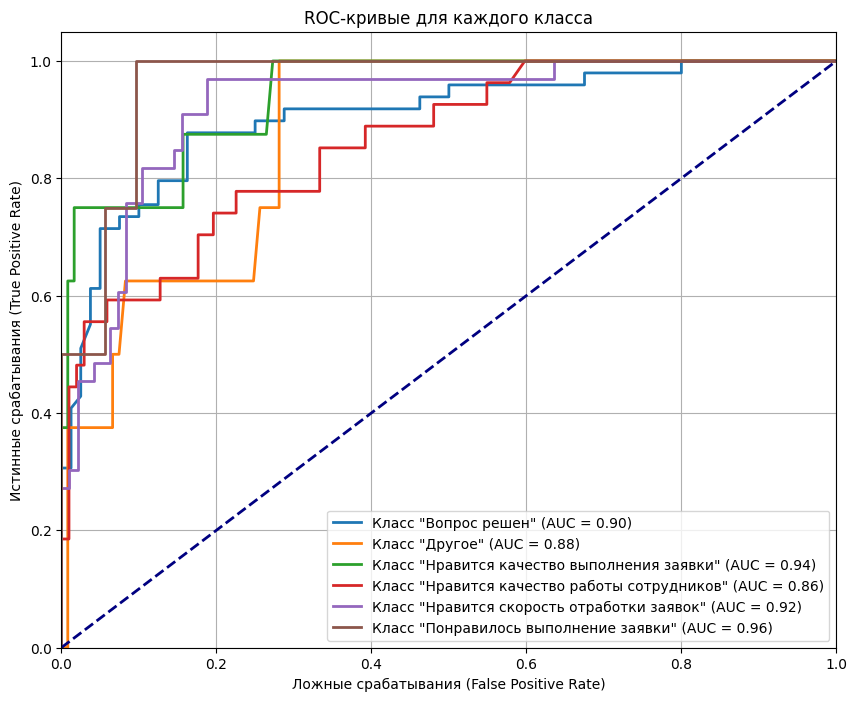

In [11]:
# После оценки модели
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Построение ROC-кривых для каждого класса
plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f'Класс "{label_encoder.classes_[i]}" (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложные срабатывания (False Positive Rate)')
plt.ylabel('Истинные срабатывания (True Positive Rate)')
plt.title('ROC-кривые для каждого класса')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()